<a href="https://colab.research.google.com/github/dishagupta0/roadmap-to-renewable-energy/blob/main/tetouan_advanced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Power Consumption Forecasting for Tetouan City - Advanced

This advanced notebook is intended for readers who are familiar with machine learning and want to explore how applying their **domain knowledge** in **feature engineering** can significantly boost model performance — even for simple models like linear regression.

We’ll demonstrate how crafting **derived features** from temporal patterns, weather variables, and energy usage insights can uncover hidden structure in the data. By bridging data science skillsets with renewable energy knowledge, we demonstrate that thoughtful feature design can outperform complex models that lack domain alignment.


## Data Loading and Initial Setup

In [ ]:
#! pip install -r requirements.txt

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import requests
import zipfile
import io
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.dates as mdates
import plotly.express as px
from statsmodels.tsa.seasonal import seasonal_decompose

# Set random seed for reproducibility
np.random.seed(42)

# Set better plot aesthetics
plt.style.use('seaborn-whitegrid')
sns.set_palette("viridis")


In [ ]:
# Download and extract CSV from ZIP
url = "https://archive.ics.uci.edu/static/public/849/power+consumption+of+tetouan+city.zip"
response = requests.get(url)
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    with z.open(z.namelist()[0]) as f:
        df = pd.read_csv(f)

# Display the first few rows
print("Dataset initial shape:", df.shape)
df.head()

Dataset initial shape: (52416, 9)


DateTime  Temperature  Humidity  Wind Speed  general diffuse flows  \
0  1/1/2017 0:00        6.559      73.8       0.083                  0.051   
1  1/1/2017 0:10        6.414      74.5       0.083                  0.070   
2  1/1/2017 0:20        6.313      74.5       0.080                  0.062   
3  1/1/2017 0:30        6.121      75.0       0.083                  0.091   
4  1/1/2017 0:40        5.921      75.7       0.081                  0.048   

   diffuse flows  Zone 1 Power Consumption  Zone 2  Power Consumption  \
0          0.119               34055.69620                16128.87538   
1          0.085               29814.68354                19375.07599   
2          0.100               29128.10127                19006.68693   
3          0.096               28228.86076                18361.09422   
4          0.085               27335.69620                17872.34043   

   Zone 3  Power Consumption  
0                20240.96386  
1                20131.08434  
2                19668.43373  
3                18899.27711  
4                18442.40964

In [ ]:
# Removes extra spacing from column names for consistency
df.rename(columns={
    'Zone 2  Power Consumption': 'Zone 2 Power Consumption',
    'Zone 3  Power Consumption': 'Zone 3 Power Consumption'
}, inplace=True)

# Convert 'DateTime' column which is currently an 'object' datatype to 'datetime' datatype and set it as index
df['DateTime'] = pd.to_datetime(df['DateTime'], dayfirst=True)
df.set_index('DateTime', inplace=True)

# Preview structure
print("\nDataset information after preprocessing:")
df.info()
# Define key column groups for easier reference
power_cols = ['Zone 1 Power Consumption', 'Zone 2 Power Consumption', 'Zone 3 Power Consumption']
weather_cols = ['Temperature', 'Humidity', 'Wind Speed', 'general diffuse flows', 'diffuse flows']


Dataset information after preprocessing:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52416 entries, 2017-01-01 00:00:00 to 2017-12-30 23:50:00
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Temperature               52416 non-null  float64
 1   Humidity                  52416 non-null  float64
 2   Wind Speed                52416 non-null  float64
 3   general diffuse flows     52416 non-null  float64
 4   diffuse flows             52416 non-null  float64
 5   Zone 1 Power Consumption  52416 non-null  float64
 6   Zone 2 Power Consumption  52416 non-null  float64
 7   Zone 3 Power Consumption  52416 non-null  float64
dtypes: float64(8)
memory usage: 3.6 MB


In [ ]:
print("\nSample data:")
df.head()


Sample data:


Temperature  Humidity  Wind Speed  general diffuse flows  \
DateTime                                                                        
2017-01-01 00:00:00        6.559      73.8       0.083                  0.051   
2017-01-01 00:10:00        6.414      74.5       0.083                  0.070   
2017-01-01 00:20:00        6.313      74.5       0.080                  0.062   
2017-01-01 00:30:00        6.121      75.0       0.083                  0.091   
2017-01-01 00:40:00        5.921      75.7       0.081                  0.048   

                     diffuse flows  Zone 1 Power Consumption  \
DateTime                                                       
2017-01-01 00:00:00          0.119               34055.69620   
2017-01-01 00:10:00          0.085               29814.68354   
2017-01-01 00:20:00          0.100               29128.10127   
2017-01-01 00:30:00          0.096               28228.86076   
2017-01-01 00:40:00          0.085               27335.69620   

                     Zone 2 Power Consumption  Zone 3 Power Consumption  
DateTime                                                                 
2017-01-01 00:00:00               16128.87538               20240.96386  
2017-01-01 00:10:00               19375.07599               20131.08434  
2017-01-01 00:20:00               19006.68693               19668.43373  
2017-01-01 00:30:00               18361.09422               18899.27711  
2017-01-01 00:40:00               17872.34043               18442.40964

## Advanced Data Pre-Processing
### Missing Values

**Simulating Missing Data for Demonstration**  
- The original dataset does not contain any missing values, which is great for modeling but limits our ability to demonstrate how to detect and handle missing data — a common challenge in real-world energy datasets.  

- To illustrate missing data analysis techniques, we create a synthetic version of the dataset by randomly introducing missing values across all columns (about 1% per column). Additionally, we simulate a contiguous block of missing data in the "Zone 1 Power Consumption" column to mimic a sensor outage or data logging failure.  

- This synthetic dataset allows us to visualize missingness patterns, calculate missing data percentages, and identify the longest contiguous gaps — all essential steps in preparing time series data for machine learning.


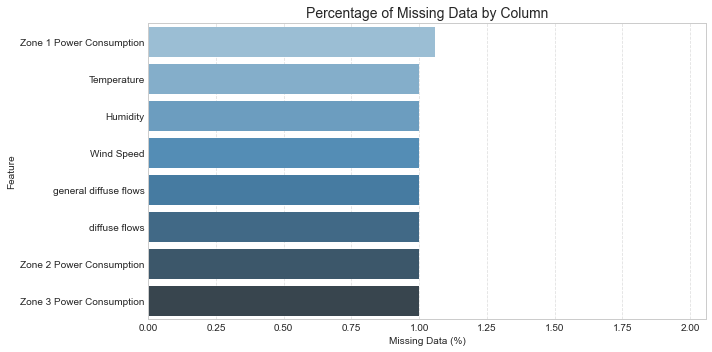


Longest contiguous periods of missing data (in 10-minute intervals):
Temperature: 2 intervals (0.3 hours)
Humidity: 2 intervals (0.3 hours)
Wind Speed: 2 intervals (0.3 hours)
general diffuse flows: 2 intervals (0.3 hours)
diffuse flows: 2 intervals (0.3 hours)
Zone 1 Power Consumption: 30 intervals (5.0 hours)
Zone 2 Power Consumption: 2 intervals (0.3 hours)
Zone 3 Power Consumption: 2 intervals (0.3 hours)


In [ ]:
# Step 1: Generate synthetic data
synthetic_df = df.copy()
np.random.seed(42)
for col in synthetic_df.columns:
    missing_indices = np.random.choice(synthetic_df.index, size=int(0.01 * len(synthetic_df)), replace=False)
    synthetic_df.loc[missing_indices, col] = np.nan
synthetic_df.iloc[10000:10030, synthetic_df.columns.get_loc('Zone 1 Power Consumption')] = np.nan

# Step 2: Visualize missing data
missing_percentage = (synthetic_df.isna().sum() / len(synthetic_df)) * 100
missing_df = pd.DataFrame({'Column': synthetic_df.columns, 'Missing (%)': missing_percentage.values})

plt.figure(figsize=(10, 5))
sns.barplot(x='Missing (%)', y='Column', data=missing_df.sort_values('Missing (%)', ascending=False), palette="Blues_d")
plt.title("Percentage of Missing Data by Column", fontsize=14)
plt.xlabel("Missing Data (%)")
plt.ylabel("Feature")
plt.xlim(0, missing_percentage.max() + 1)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Step 3: Contiguous gap detection
missing_periods = {}
for col in synthetic_df.columns:
    is_na = synthetic_df[col].isna()
    if not is_na.any():
        continue
    na_groups = (is_na != is_na.shift()).cumsum()
    runs = na_groups[is_na].value_counts().sort_index()
    longest = runs.max()
    missing_periods[col] = longest

print("\nLongest contiguous periods of missing data (in 10-minute intervals):")
for col, length in missing_periods.items():
    print(f"{col}: {length} intervals ({length * 10 / 60:.1f} hours)")


In [ ]:
# Interpolate weather-related features with appropriate method
print("Missing values before interpolation:", synthetic_df[weather_cols].isna().sum())
synthetic_df[weather_cols] = synthetic_df[weather_cols].interpolate(method='time')

# For power consumption, use a combination of interpolation methods
synthetic_df[power_cols] = synthetic_df[power_cols].interpolate(method='linear', limit=6)
synthetic_df[power_cols] = synthetic_df[power_cols].interpolate(method='time')
synthetic_df[power_cols] = synthetic_df[power_cols].fillna(method='ffill').fillna(method='bfill')

# Verify missing value treatment
print("Missing values after interpolation:", synthetic_df.isna().sum())

remaining_na = synthetic_df.isna().sum().sum()
if remaining_na > 0:
    print(f"Removing {synthetic_df.isna().any(axis=1).sum()} rows with remaining NaN values")
    synthetic_df = synthetic_df.dropna()
else:
    print("No NaN values remaining in the dataset")


Missing values before interpolation: Temperature              524
Humidity                 524
Wind Speed               524
general diffuse flows    524
diffuse flows            524
dtype: int64
Missing values after interpolation: Temperature                 0
Humidity                    0
Wind Speed                  0
general diffuse flows       0
diffuse flows               0
Zone 1 Power Consumption    0
Zone 2 Power Consumption    0
Zone 3 Power Consumption    0
dtype: int64
No NaN values remaining in the dataset


### Outlier Detection and Treatment

Detecting and treating outliers in power consumption data:
Zone 1 Power Consumption - Outliers: 1050 (2.00%)
  Lower bound: 20274.81, Upper bound: 48099.48


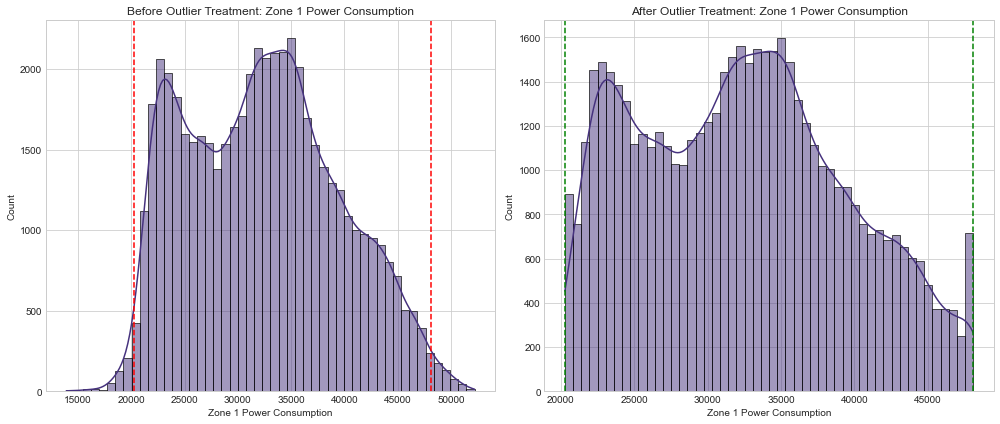

Zone 2 Power Consumption - Outliers: 1050 (2.00%)
  Lower bound: 11631.70, Upper bound: 33734.95


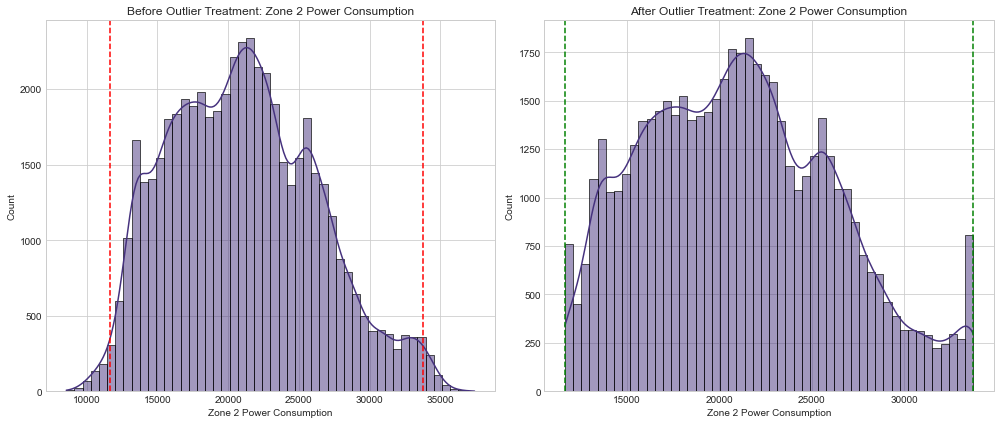

Zone 3 Power Consumption - Outliers: 1048 (2.00%)
  Lower bound: 7726.27, Upper bound: 38722.44


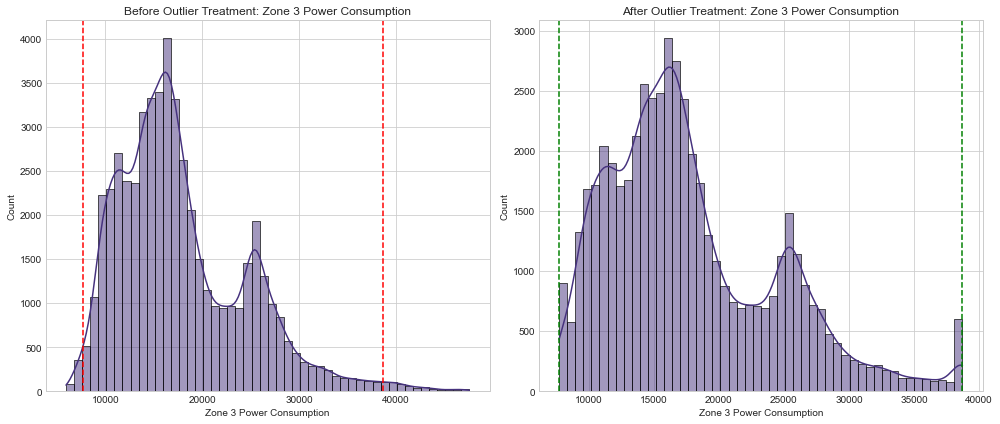


Detecting and treating outliers in weather data:
Temperature - Outliers: 1050 (2.00%)
  Lower bound: 6.76, Upper bound: 33.16
Humidity - Outliers: 1041 (1.99%)
  Lower bound: 27.33, Upper bound: 92.00
Wind Speed - Outliers: 1030 (1.97%)
  Lower bound: 0.07, Upper bound: 4.93
general diffuse flows - Outliers: 846 (1.61%)
  Lower bound: 0.02, Upper bound: 885.00
diffuse flows - Outliers: 934 (1.78%)
  Lower bound: 0.06, Upper bound: 596.80


In [ ]:
# Define outlier detection and capping function
def detect_and_cap_outliers(df, column, lower_quantile=0.01, upper_quantile=0.99, plot=True):
    original_values = df[column].copy()
    lower_bound = df[column].quantile(lower_quantile)
    upper_bound = df[column].quantile(upper_quantile)
    outliers = (df[column] < lower_bound) | (df[column] > upper_bound)
    outlier_count = outliers.sum()
    outlier_percentage = (outlier_count / len(df)) * 100

    print(f"{column} - Outliers: {outlier_count} ({outlier_percentage:.2f}%)")
    print(f"  Lower bound: {lower_bound:.2f}, Upper bound: {upper_bound:.2f}")

    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)

    if plot and outlier_count > 0:
        plt.figure(figsize=(14, 6))
        plt.subplot(1, 2, 1)
        sns.histplot(original_values, bins=50, kde=True)
        plt.axvline(lower_bound, color='r', linestyle='--')
        plt.axvline(upper_bound, color='r', linestyle='--')
        plt.title(f"Before Outlier Treatment: {column}")
        plt.subplot(1, 2, 2)
        sns.histplot(df[column], bins=50, kde=True)
        plt.axvline(lower_bound, color='g', linestyle='--')
        plt.axvline(upper_bound, color='g', linestyle='--')
        plt.title(f"After Outlier Treatment: {column}")
        plt.tight_layout()
        plt.show()

    return df

# Apply to power and weather columns
print("Detecting and treating outliers in power consumption data:")
for col in power_cols:
    df = detect_and_cap_outliers(df, col)

print("\nDetecting and treating outliers in weather data:")
for col in weather_cols:
    df = detect_and_cap_outliers(df, col, plot=False)

## Advanced Feature Engineering

### Temporal Patterns in Power Consumption

In [ ]:
# Add temporal features for grouping
df['hour'] = df.index.hour
df['day'] = df.index.day
df['weekday'] = df.index.weekday
df['month'] = df.index.month
df['quarter'] = df.index.quarter
df['is_weekend'] = df['weekday'].isin([5, 6]).astype(int)

# Resample to daily data for easier visualization of trends
df_daily = df[power_cols].resample('D').mean()

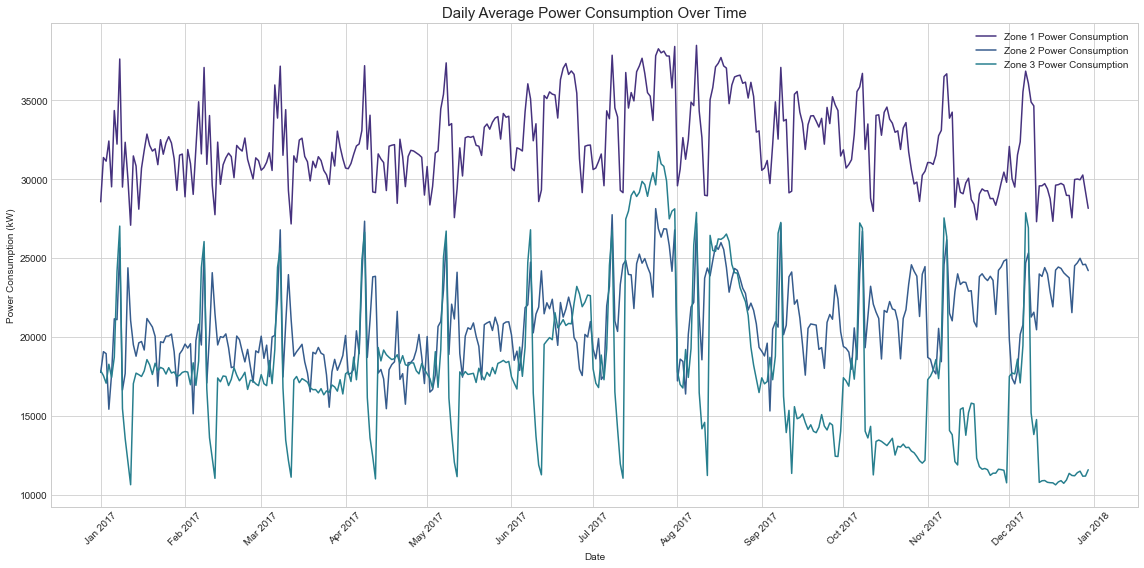

In [ ]:
# Plot daily average power consumption over time
plt.figure(figsize=(16, 8))
for col in power_cols:
    plt.plot(df_daily.index, df_daily[col], label=col)
plt.title("Daily Average Power Consumption Over Time", fontsize=15)
plt.xlabel("Date")
plt.ylabel("Power Consumption (kW)")
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

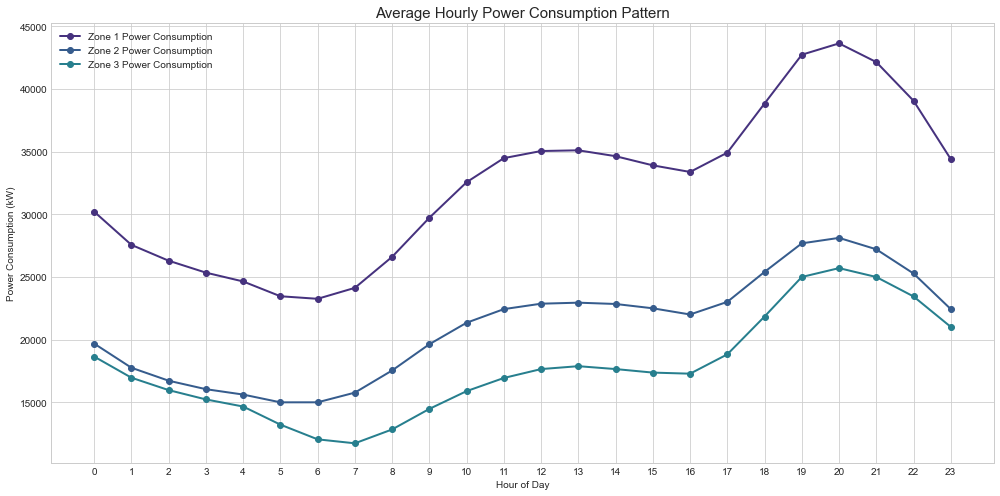

In [ ]:
# Plot hourly patterns
hourly_avg = df.groupby('hour')[power_cols].mean()
plt.figure(figsize=(14, 7))
for col in power_cols:
    plt.plot(hourly_avg.index, hourly_avg[col], marker='o', linewidth=2, label=col)
plt.title("Average Hourly Power Consumption Pattern", fontsize=15)
plt.xlabel("Hour of Day")
plt.ylabel("Power Consumption (kW)")
plt.xticks(range(0, 24))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

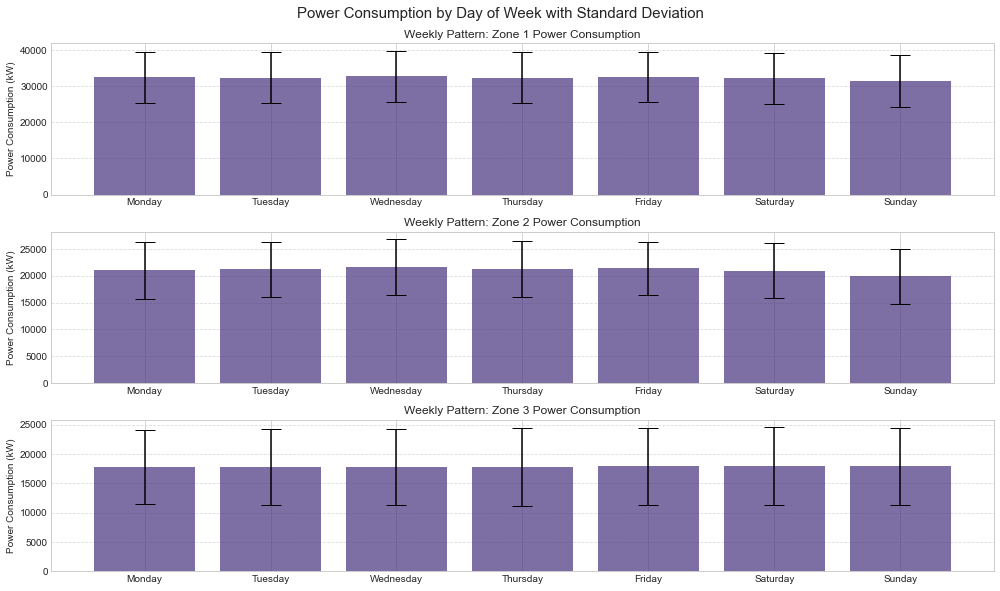

In [ ]:
# Weekly pattern with standard deviation
weekly_avg = df.groupby('weekday')[power_cols].agg(['mean', 'std'])
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(14, 8))
for i, col in enumerate(power_cols):
    plt.subplot(3, 1, i+1)
    means = weekly_avg[col]['mean'].values
    stds = weekly_avg[col]['std'].values
    plt.bar(days, means, yerr=stds, capsize=10, alpha=0.7)
    plt.title(f"Weekly Pattern: {col}", fontsize=12)
    plt.ylabel("Power Consumption (kW)")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.suptitle("Power Consumption by Day of Week with Standard Deviation", y=1.02, fontsize=15)
plt.show()

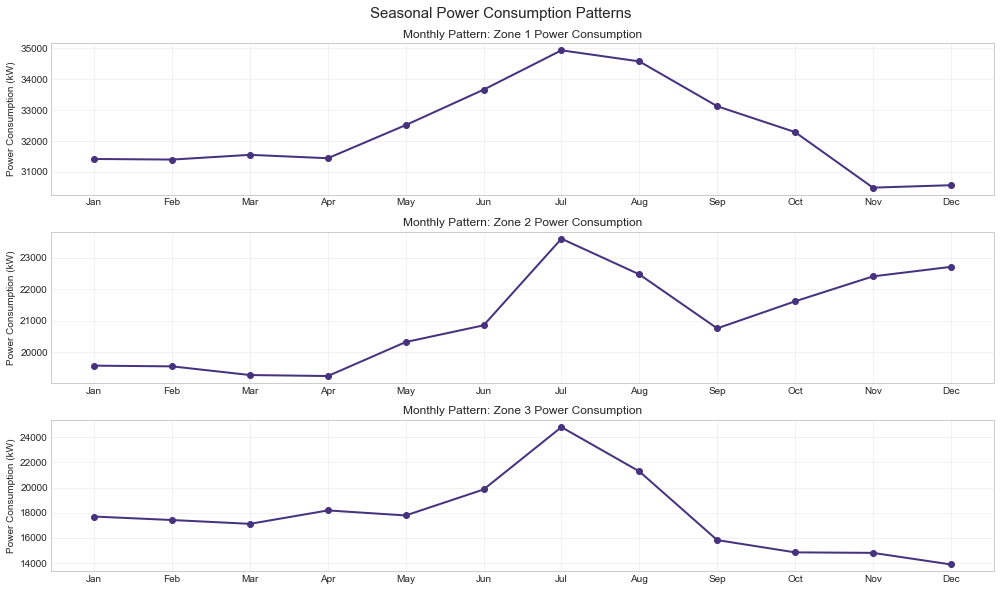

In [ ]:
# Monthly patterns
monthly_avg = df.groupby('month')[power_cols].mean()
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

plt.figure(figsize=(14, 8))
for i, col in enumerate(power_cols):
    plt.subplot(3, 1, i+1)
    plt.plot(months, monthly_avg[col].values, marker='o', linewidth=2)
    plt.title(f"Monthly Pattern: {col}", fontsize=12)
    plt.ylabel("Power Consumption (kW)")
    plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.suptitle("Seasonal Power Consumption Patterns", y=1.02, fontsize=15)
plt.show()

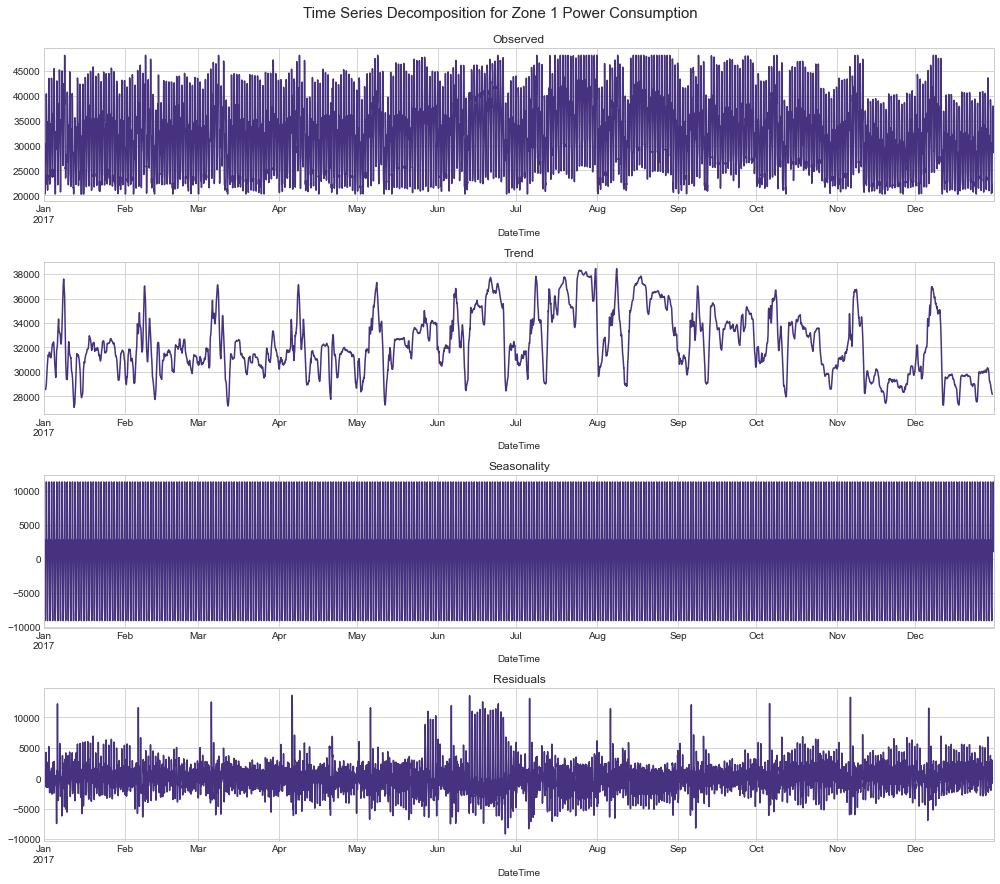

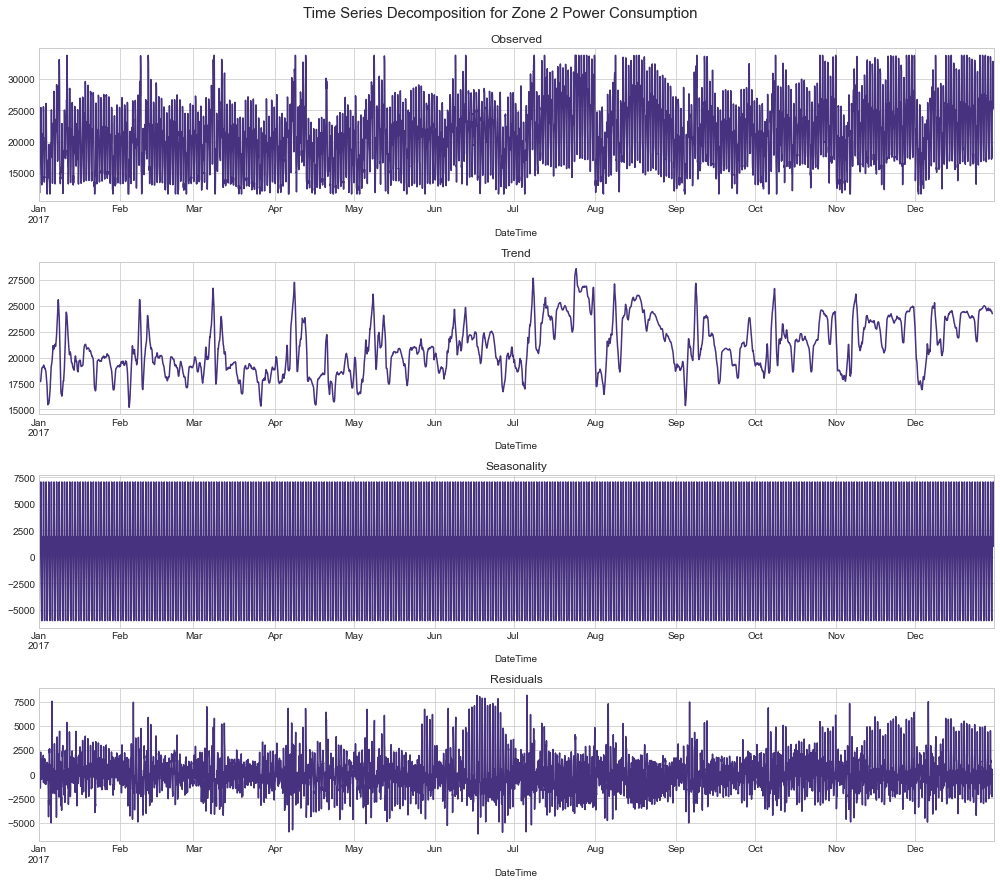

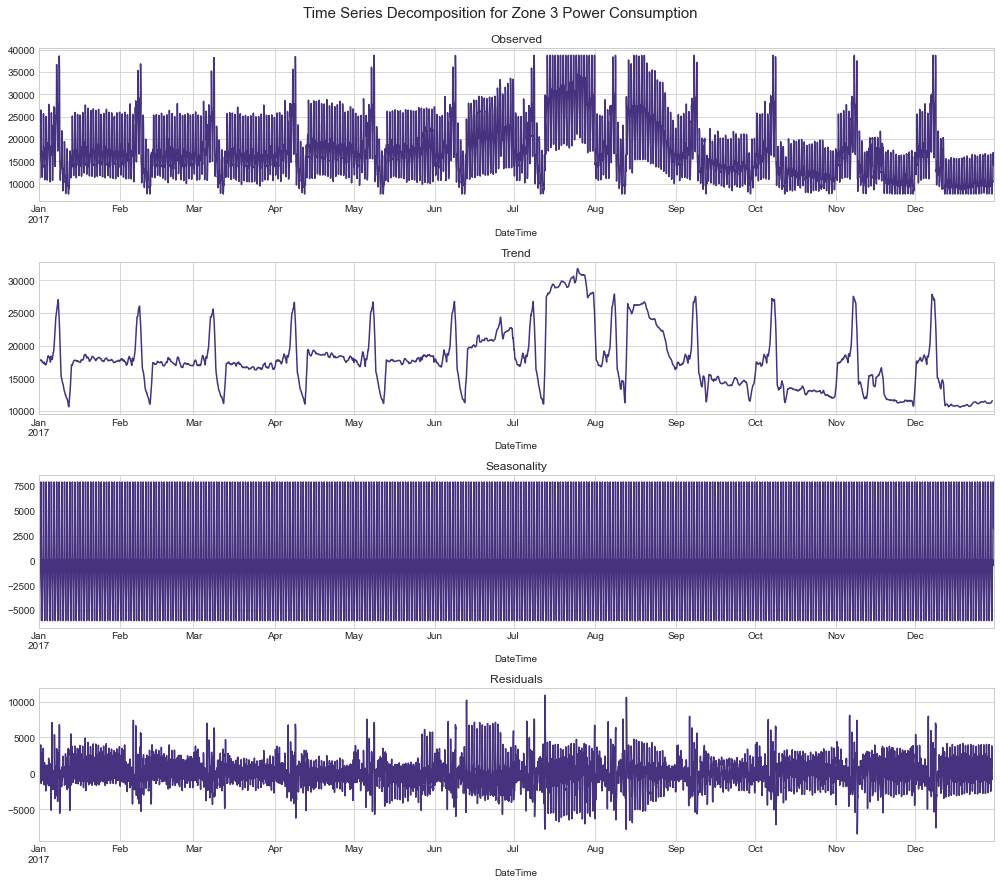

In [ ]:
# Time series decomposition
for col in power_cols:
    hourly_data = df[col].resample('H').mean()
    decomposition = seasonal_decompose(hourly_data.dropna(), period=24)
    fig, axes = plt.subplots(4, 1, figsize=(14, 12))
    decomposition.observed.plot(ax=axes[0], title='Observed')
    decomposition.trend.plot(ax=axes[1], title='Trend')
    decomposition.seasonal.plot(ax=axes[2], title='Seasonality')
    decomposition.resid.plot(ax=axes[3], title='Residuals')
    plt.tight_layout()
    plt.suptitle(f"Time Series Decomposition for {col}", y=1.02, fontsize=15)
    plt.show()

### Weather Impact on Consumption

In [ ]:
# Create interactive scatter plots for weather vs power consumption
for zone in power_cols:
    fig = px.scatter(df.sample(5000),
                     x="Temperature",
                     y=zone,
                     color="hour",
                     hover_data=["Wind Speed", "Humidity"],
                     title=f"Temperature vs {zone} by Hour of Day",
                     labels={"Temperature": "Temperature (°C)", zone: "Power Consumption (kW)"},
                     color_continuous_scale=px.colors.sequential.Viridis)
    fig.update_layout(width=900, height=600)
    fig.show()

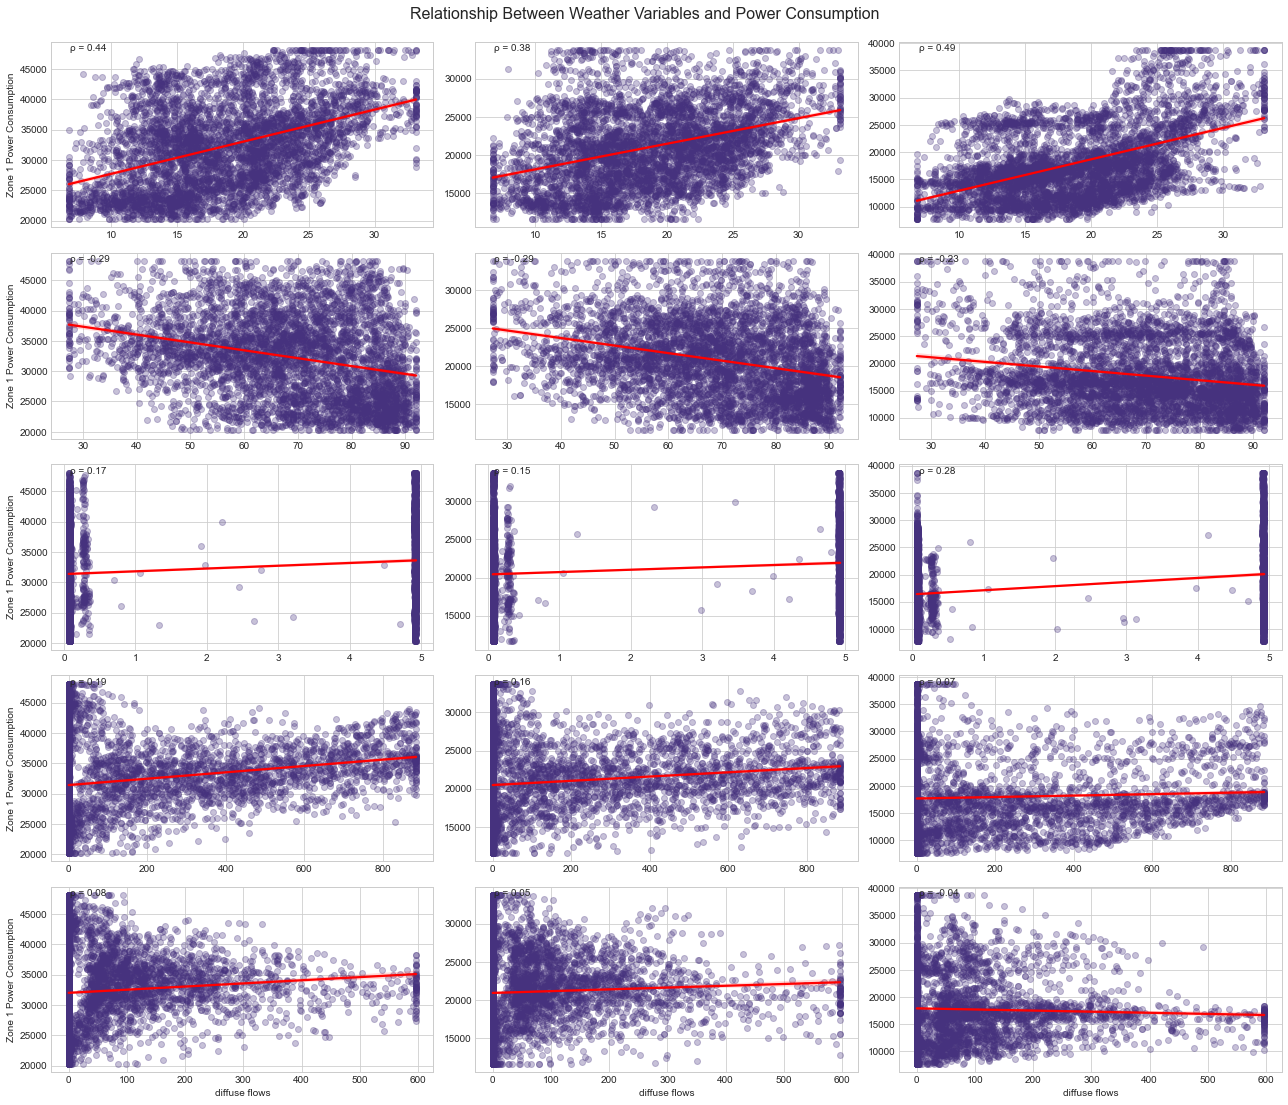

In [ ]:
# Create a grid of scatter plots showing relationships between weather variables and power consumption
fig, axes = plt.subplots(len(weather_cols), len(power_cols), figsize=(18, 15))

for i, weather in enumerate(weather_cols):
    for j, zone in enumerate(power_cols):
        sample_df = df.sample(5000)
        sns.regplot(x=weather, y=zone, data=sample_df, scatter_kws={'alpha':0.3},
                    line_kws={'color':'red'}, ax=axes[i, j])
        corr = df[weather].corr(df[zone])
        axes[i, j].annotate(f'ρ = {corr:.2f}', xy=(0.05, 0.95), xycoords='axes fraction')
        if i == len(weather_cols)-1:
            axes[i, j].set_xlabel(weather)
        else:
            axes[i, j].set_xlabel('')
        if j == 0:
            axes[i, j].set_ylabel(zone)
        else:
            axes[i, j].set_ylabel('')

plt.tight_layout()
plt.suptitle("Relationship Between Weather Variables and Power Consumption", y=1.02, fontsize=16)
plt.show()

### Enhanced Temporal & Cyclical Features

In [ ]:
# Temporal features
df['is_workday'] = (~df['weekday'].isin([5, 6])).astype(int)

# Time of day categories
df['time_of_day'] = pd.cut(
    df['hour'],
    bins=[0, 6, 12, 18, 24],
    labels=['Night', 'Morning', 'Afternoon', 'Evening'],
    include_lowest=True
)

# One-hot encode time of day
tod_dummies = pd.get_dummies(df['time_of_day'], prefix='tod')
df = pd.concat([df, tod_dummies], axis=1)

# Cyclical encoding
def cyclical_encoding(df, col, period):
    df[f'{col}_sin'] = np.sin(2 * np.pi * df[col] / period)
    df[f'{col}_cos'] = np.cos(2 * np.pi * df[col] / period)
    return df

df = cyclical_encoding(df, 'hour', 24)
df = cyclical_encoding(df, 'weekday', 7)
df = cyclical_encoding(df, 'month', 12)
df = cyclical_encoding(df, 'day', 31)

# Weekend-hour interaction
for h in range(24):
    df[f'weekend_hour_{h}'] = ((df['hour'] == h) &
                                         (df['is_weekend'] == 1)).astype(int)

### Advanced Lag and Rolling Features

In [ ]:
# Define lag intervals (10-minute intervals)
lag_intervals = {
    '30min': 3,
    '1hr': 6,
    '3hr': 18,
    '6hr': 36,
    '12hr': 72,
    '1day': 144,
    '1week': 1008
}

# Create lag features
for col in power_cols:
    for name, lag in lag_intervals.items():
        df[f'{col}_lag_{name}'] = df[col].shift(lag)

In [ ]:
# Create rolling statistics for power consumption
rolling_windows = [6, 12, 36, 72, 144]  # corresponds to 1hr, 2hr, 6hr, 12hr, 1day

for col in power_cols:
    for window in rolling_windows:
        df[f'{col}_roll_mean_{window}'] = df[col].rolling(window=window, min_periods=1).mean()
        df[f'{col}_roll_std_{window}'] = df[col].rolling(window=window, min_periods=1).std()
        df[f'{col}_roll_min_{window}'] = df[col].rolling(window=window, min_periods=1).min()
        df[f'{col}_roll_max_{window}'] = df[col].rolling(window=window, min_periods=1).max()
        df[f'{col}_roll_range_{window}'] = (
            df[f'{col}_roll_max_{window}'] - df[f'{col}_roll_min_{window}']
        )

# Rolling means for weather features
for col in weather_cols:
    df[f'{col}_roll_mean_6'] = df[col].rolling(window=6, min_periods=1).mean()
    df[f'{col}_roll_mean_36'] = df[col].rolling(window=36, min_periods=1).mean()

### Derived and Interaction Features

In [ ]:
# Weather interaction features
df['temp_x_humidity'] = df['Temperature'] * df['Humidity'] / 100
df['temp_x_wind'] = df['Temperature'] * df['Wind Speed']
df['feels_like'] = df['Temperature'] - 0.2 * (100 - df['Humidity']) / 5
df['wind_chill'] = (
    13.12 + 0.6215 * df['Temperature'] -
    11.37 * (df['Wind Speed'] ** 0.16) +
    0.3965 * df['Temperature'] * (df['Wind Speed'] ** 0.16)
)

# Power consumption aggregates
df['total_power'] = df[power_cols].sum(axis=1)
df['avg_power'] = df[power_cols].mean(axis=1)

# Create zone ratios
for i in range(len(power_cols)):
    for j in range(i+1, len(power_cols)):
        col_i = power_cols[i]
        col_j = power_cols[j]
        ratio_name = f'ratio_{col_i.split()[1]}_{col_j.split()[1]}'
        df[ratio_name] = df[col_i] / (df[col_j] + 1)  # Avoid division by zero

In [ ]:
# Rate of change and percent change
for col in power_cols:
    df[f'{col}_diff'] = df[col].diff()
    df[f'{col}_pct_change'] = df[col].pct_change() * 100

# Time since peak feature
for col in power_cols:
    threshold = df[col].quantile(0.95)
    df[f'{col}_is_peak'] = (df[col] > threshold).astype(int)
    peak_indices = df.index[df[f'{col}_is_peak'] == 1]
    time_since_peak = pd.Series(index=df.index)
    for idx in df.index:
        previous_peaks = peak_indices[peak_indices < idx]
        if len(previous_peaks) > 0:
            most_recent_peak = previous_peaks[-1]
            time_since_peak.loc[idx] = (idx - most_recent_peak).total_seconds() / 3600
        else:
            time_since_peak.loc[idx] = 24 * 7
    df[f'{col}_hours_since_peak'] = time_since_peak

## Feature Selection and Model Preparation

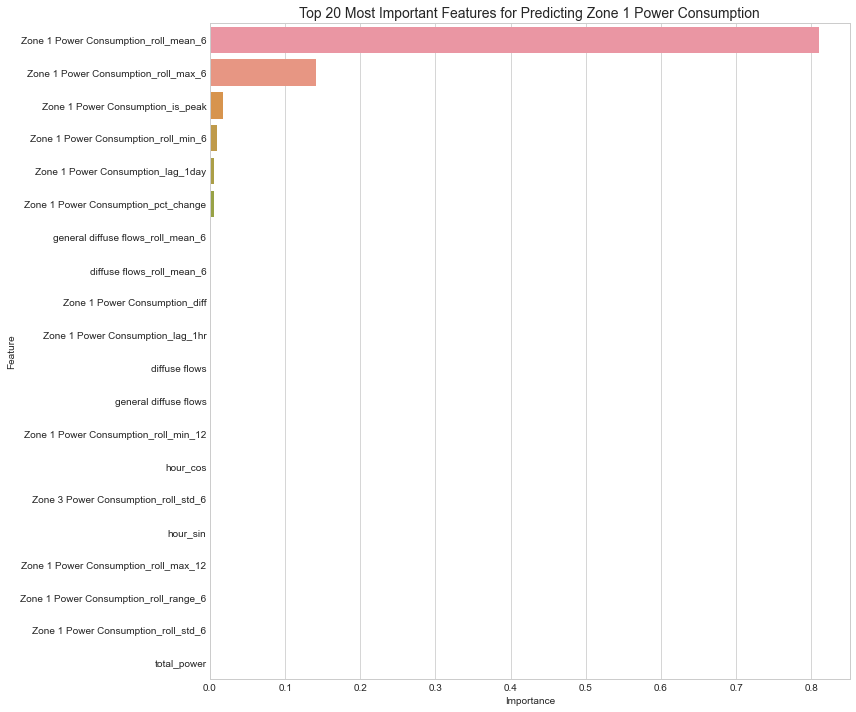

Top 5 most important features:
                                  Feature  Importance
64   Zone 1 Power Consumption_roll_mean_6    0.810322
67    Zone 1 Power Consumption_roll_max_6    0.140403
164      Zone 1 Power Consumption_is_peak    0.017336
66    Zone 1 Power Consumption_roll_min_6    0.009967
48      Zone 1 Power Consumption_lag_1day    0.005785

Selected 20 features for modeling.


In [ ]:
# Drop rows with any NaNs created during lag/rolling feature generation
df_clean = df.dropna()

# Define target and exclude original raw columns and categorical ones
target = 'Zone 1 Power Consumption'
exclude_cols = power_cols + ['hour', 'weekday', 'month', 'day', 'quarter', 'time_of_day']
features = [col for col in df_clean.columns if col not in exclude_cols and df_clean[col].dtype != 'object']

X_og = X = df_clean[features]
y_og = y = df_clean[target]

# Fit a Random Forest for feature importance
rf_importance = RandomForestRegressor(n_estimators=40, random_state=42)
rf_importance.fit(X, y)

# Store and display importance
importances = rf_importance.feature_importances_
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values('Importance', ascending=False)

# Plot top 20 most important features
plt.figure(figsize=(12, 10))
top_features = importance_df.head(20)
sns.barplot(x='Importance', y='Feature', data=top_features)
plt.title('Top 20 Most Important Features for Predicting Zone 1 Power Consumption', fontsize=14)
plt.tight_layout()
plt.show()

print("Top 5 most important features:")
print(importance_df.head(5))

# Select top 20 features for modeling
top_features_list = importance_df.head(20)['Feature'].tolist()
print(f"\nSelected {len(top_features_list)} features for modeling.")

## Model Training and Evaluation

In [ ]:
# Helper function to evaluate models
def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    metrics = {
        'Model': name,
        'Train R2': r2_score(y_train, y_pred_train),
        'Test R2': r2_score(y_test, y_pred_test),
        'Train RMSE': np.sqrt(mean_squared_error(y_train, y_pred_train)),
        'Test RMSE': np.sqrt(mean_squared_error(y_test, y_pred_test)),
        'Train MAE': mean_absolute_error(y_train, y_pred_train),
        'Test MAE': mean_absolute_error(y_test, y_pred_test),
        'Test MAPE': np.mean(np.abs((y_test - y_pred_test) / (y_test + 1e-5))) * 100
    }
    return metrics,y_pred_test

# Prepare data
X = df_clean[top_features_list]
y = df_clean[target]
split_index = int(len(df_clean) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]


- Let's call our new Linear Regression model containing advanced feature engineering as Advanced Linear Regression.

- We compare our results against all the models from the basic notebook.


In [ ]:
results_df = pd.read_csv('basic_nb_eval_results.csv')

name = 'Advanced Linear Regression'
metrics, y_pred = evaluate_model(name, LinearRegression(), X_train, y_train, X_test, y_test)

# Append the metrics dict as a new row to results_df
results_df = pd.concat([results_df, pd.DataFrame([metrics])])
results_df.set_index("Model", inplace=True)
results_df.sort_values("Test R2", ascending=False, inplace=True)

# Show results
display(results_df)

Train R2   Test R2   Train RMSE    Test RMSE  \
Model                                                                      
Advanced Linear Regression  0.997980  0.998060   319.140468   269.709511   
Gradient Boosting           0.362081  0.048759  5729.333537  6014.169853   
Lasso Regression            0.192089  0.044084  6447.676267  6028.931950   
Ridge Regression            0.192089  0.044084  6447.676267  6028.932342   
Linear Regression           0.192089  0.044084  6447.676267  6028.932599   
Random Forest               0.947564 -0.223839  1642.615408  6821.700465   

                              Train MAE     Test MAE  Test MAPE  
Model                                                            
Advanced Linear Regression   210.150322   182.464885   0.621432  
Gradient Boosting           4507.037797  4774.936183  17.942949  
Lasso Regression            5314.320299  5082.744315  18.928821  
Ridge Regression            5314.320325  5082.744596  18.928823  
Linear Regression           5314.320342  5082.744456  18.928821  
Random Forest               1089.681304  5008.637028  18.873822

In [ ]:
# Compute % improvements
adv = results_df.loc['Advanced Linear Regression']
gb = results_df.loc['Gradient Boosting']
higher_is_better = ['Train R2', 'Test R2']

improvements = {
    col: ((adv[col] - gb[col]) / abs(gb[col]) * 100) if col in higher_is_better
    else ((gb[col] - adv[col]) / abs(gb[col]) * 100)
    for col in results_df.columns
}

# Print Test R2 improvement
test_r2_improvement = improvements['Test R2']
print(f"Advanced Linear Regression improved Test R² by {test_r2_improvement:.2f}% over Gradient Boosting!!!")

Advanced Linear Regression improved Test R² by 1946.91% over Gradient Boosting!!!


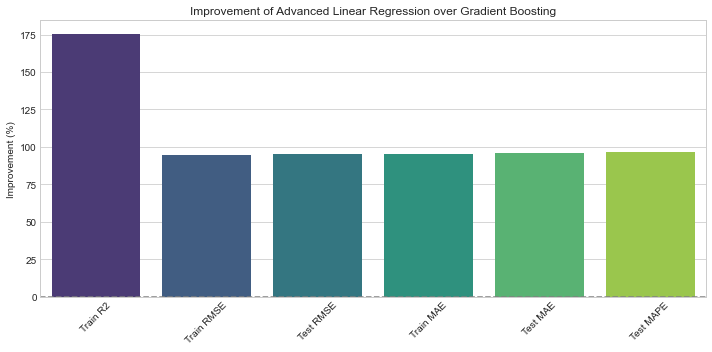

In [ ]:
# Compare other metrics
other_metrics = {k: v for k, v in improvements.items() if k != 'Test R2'}

plt.figure(figsize=(10, 5))
sns.barplot(x=list(other_metrics.keys()), y=list(other_metrics.values()), palette='viridis')
plt.axhline(0, color='gray', linestyle='--')
plt.ylabel('Improvement (%)')
plt.title('Improvement of Advanced Linear Regression over Gradient Boosting')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Visualizing Predictions

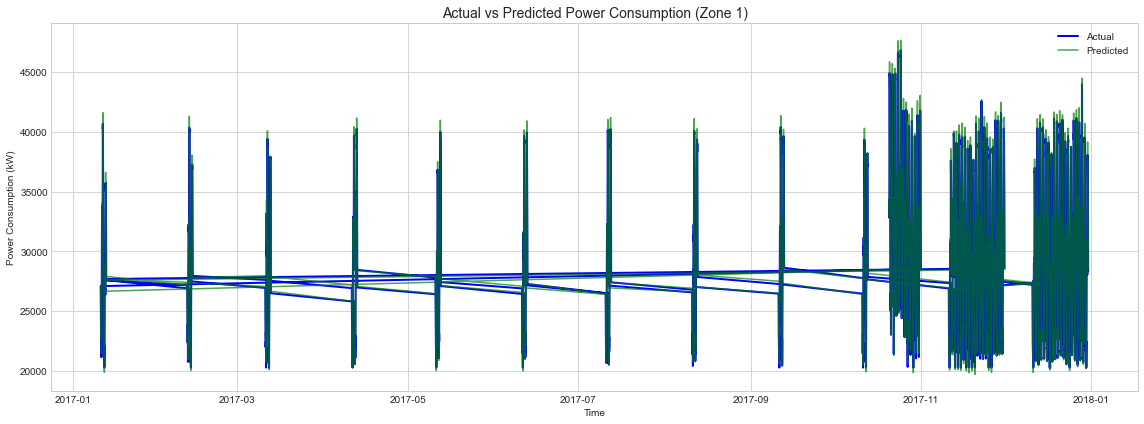

In [ ]:
# Plot actual vs predicted values over time
plt.figure(figsize=(16, 6))
plt.plot(y_test.index, y_test.values, label='Actual', color='blue', linewidth=2)
plt.plot(y_test.index, y_pred, label='Predicted', color='green', alpha=0.7)
plt.title("Actual vs Predicted Power Consumption (Zone 1)", fontsize=14)
plt.xlabel("Time")
plt.ylabel("Power Consumption (kW)")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

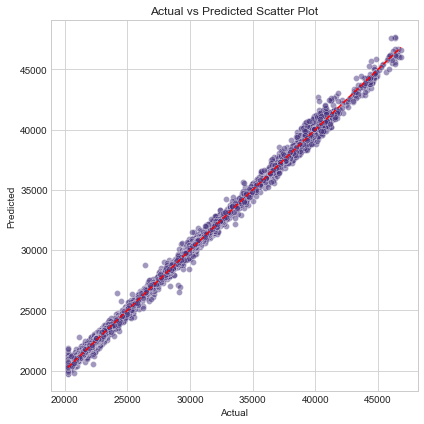

In [ ]:
# Scatter plot of actual vs predicted
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted Scatter Plot")
plt.grid(True)
plt.tight_layout()
plt.show()

## Conclusion

In this notebook, we developed a robust machine learning pipeline to forecast zone-wise electricity consumption in Tetouan City using weather and temporal data. Key steps included:

- **Data cleaning and preprocessing** of the UCI dataset  
- **Exploratory data analysis** covering missing values, temporal patterns, and weather impact  
- **Advanced feature engineering** with lag, rolling, and derived features  
- **Evaluation and visualization** of prediction accuracy  

I encourage you to experiment further using the tools and techniques demonstrated throughout these notebooks — there's plenty of opportunity to explore and improve predictive performance on your own! To get started, here are a few ideas:

- Extend modeling to **all** zones using multi-output regression  
- Incorporate external events and holidays to capture demand spikes  
- Experiment with non-linear models, ensembling strategies, or temporal deep learning (e.g., LSTMs or TCNs)  
- Try model interpretability techniques like **SHAP** to better understand driver variables.  
